<a href="https://colab.research.google.com/github/onealkeegan/DNSC-3288-Predict-Future-Sales/blob/main/DNSC_3288_Predict_Future_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# DNSC-3288-Predict-Future-Sales
#Predicting future sales for Fall 2025 Solo Final Project

In [ ]:
pip install category_encoders

AI Use Disclosure: The code below is based heavily on this (xxxxxxx) Kaggle dataset. After pre-processing, CHATGPT 5.0 was utilized to help me write more optimized code. ChatGPT 5.0 is reliable at coding, NOT reason based arguments, therefore its' help with coding was able to save me time to focus instead on my model card.

#1. Insert Packages & Import Data

In [ ]:
import pandas as pd
import numpy as np
from itertools import product
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
import category_encoders as ce
import warnings

pd.set_option('display.max_rows', 400)
pd.set_option('display.max_columns', 160)
pd.set_option('display.max_colwidth', 40)
warnings.filterwarnings("ignore")

In [ ]:
#import test data
test = pd.read_csv('/kaggle/input/future-sales-data/test.csv')
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


### Import Categories

Feature Engineering/LightGBM/Exploring Performance - https://www.kaggle.com/code/deepdivelm/feature-engineering-lightgbm-exploring-performance/notebook had english translations

In [ ]:
categories = pd.read_csv('/kaggle/input/future-sales-data/categories.csv')
categories

,category_name,category_id
0,PC - Headsets / Headphones,0
1,Accessories - PS2,1
2,Accessories - PS3,2
3,Accessories - PS4,3
4,Accessories - PSP,4
5,Accessories - PSVita,5
6,Accessories - XBOX 360,6
7,Accessories - XBOX ONE,7
8,Tickets (Digital),8
9,Delivery of goods,9


In [ ]:
pd.DataFrame(categories.category_name.values.reshape(-1, 4))

,0,1,2,3
0,PC - Headsets / Headphones,Accessories - PS2,Accessories - PS3,Accessories - PS4
1,Accessories - PSP,Accessories - PSVita,Accessories - XBOX 360,Accessories - XBOX ONE
2,Tickets (Digital),Delivery of goods,Game consoles - PS2,Game consoles - PS3
3,Game consoles - PS4,Game consoles - PSP,Game consoles - PSVita,Game consoles - XBOX 360
4,Game consoles - XBOX ONE,Game consoles - Others,Games - PS2,Games - PS3
5,Games - PS4,Games - PSP,Games - PSVita,Games - XBOX 360
6,Games - XBOX ONE,Games - Game accessories,Android games - Number,MAC Games - Number
7,PC Games - Additional Editions,PC Games - Collector's Editions,PC Games - Standard Editions,PC Games - Digital
8,"Payment Cards (Cinema, Music, Games)",Payment Cards - Live!,Payment Cards - Live! (Digital),Payment cards - PSN
9,Payment cards - Windows (Digital),Cinema - Blu-Ray,Cinema - Blu-Ray 3D,Cinema - Blu-Ray 4K


In [ ]:
#Not all category names have a '-' between the main category and the subcategory.
#We create groups by extracting the part of the name prior to a non-letter character.
#We then create a group_id column by label encoding the group names.

In [ ]:
#create broader category groupings
categories['group_name'] = categories['category_name'].str.extract(r'(^[\w\s]*)')
categories['group_name'] = categories['group_name'].str.strip()
#label encode group names
categories['group_id']  = le.fit_transform(categories.group_name.values)
categories.sample(5)

,category_name,category_id,group_name,group_id
34,Payment Cards - Live! (Digital),34,Payment Cards,14
44,Books - Audiobooks (Digit),44,Books,4
1,Accessories - PS2,1,Accessories,0
43,Books - Audiobooks,43,Books,4
81,Blank media (spire),81,Blank media,3


### Import Items

In [ ]:
#We load items.csv, clean the name column, create multiple features based on the cleaned name, and use label encoding.
#The categories dataframe is then joined to the items dataframe.

In [ ]:
#load items
items = pd.read_csv('/kaggle/input/future-sales-data/items.csv')
items

,item_id,category_id,item_name
0,0,40,!! IN THE POWER OF HAPPINESS (PLAST) D
1,1,76,! ABBYY FineReader 12 Professional E...
2,2,40,*** IN THE GLORY OF THE GLORY (UNV) D
3,3,40,*** BLUE WAVE (Univ) D
4,4,40,*** BOX (GLASS) D
...,...,...,...
22165,22165,31,"Nuclear Titbit 2 [PC, Digital Version]"
22166,22166,54,Query language 1C: Enterprise [Digit...
22167,22167,49,The query language is 1C: Enterprise...
22168,22168,62,Egg for Little Inu


In [ ]:
#clean item_name
items['item_name'] = items['item_name'].str.lower()
items['item_name'] = items['item_name'].str.replace('.', '')
for i in [r'[^\w\d\s\.]', r'\bthe\b', r'\bin\b', r'\bis\b',
          r'\bfor\b', r'\bof\b', r'\bon\b', r'\band\b',
          r'\bto\b', r'\bwith\b' , r'\byo\b']:
    items['item_name'] = items['item_name'].str.replace(i, ' ')
items['item_name'] = items['item_name'].str.replace(r'\b.\b', ' ')


In [ ]:
#extract first n characters of name
items['item_name_no_space'] = items['item_name'].str.replace(' ', '')
items['item_name_first4'] = [x[:4] for x in items['item_name_no_space']]
items['item_name_first6'] = [x[:6] for x in items['item_name_no_space']]
items['item_name_first11'] = [x[:11] for x in items['item_name_no_space']]
del items['item_name_no_space']

In [ ]:
#label encode these columns
items.item_name_first4 = le.fit_transform(items.item_name_first4.values)
items.item_name_first6 = le.fit_transform(items.item_name_first6.values)
items.item_name_first11 = le.fit_transform(items.item_name_first11.values)

In [ ]:
#join category_name, group_name and group_id to items
items = items.join(categories.set_index('category_id'), on='category_id')
items.sample(10)

,item_id,category_id,item_name,item_name_first4,item_name_first6,item_name_first11,category_name,group_name,group_id
4279,4279,31,"la noire [pc, digital version]",1801,3062,5542,PC Games - Digital,PC Games,13
14362,14362,58,margulis evgeniy eugene margulis lp,1992,3416,6107,Music - Vinyl,Music,11
3646,3646,55,guetta david one love,1373,2397,4448,Music - CD of local production,Music,11
18254,18254,55,sat romantic melodies spanish guitar,2843,4900,8772,Music - CD of local production,Music,11
7526,7526,55,v / a excellent songs of radio 7 on ...,3453,6219,11154,Music - CD of local production,Music,11
3635,3635,30,grid autosport limited black edition...,1359,2380,4424,PC Games - Standard Editions,PC Games,13
654,654,77,1c: educational collection soon to s...,59,76,96,Programs - Educational,Programs,16
20198,20198,58,fedorov and kruzenstern being everyw...,1152,1987,3617,Music - Vinyl,Music,11
10244,10244,78,virtual laboratory work on physics 7...,3519,6351,11367,Programs - Educational (Digit),Programs,16
430,430,45,1c: audio theater collection of fair...,55,67,86,Books - Audiobooks 1C,Books,4


In [ ]:
#Duplicate rows exist in the item list.
#The following cell creates a dictionary that will allow us to reassign item id's where appropriate.

In [ ]:
dupes = items[(items.duplicated(subset=['item_name','category_id'],keep=False))]
dupes['in_test'] = dupes.item_id.isin(test.item_id.unique())
dupes = dupes.groupby('item_name').agg({'item_id':['first','last'],'in_test':['first','last']})

#if both item id's are in the test set do nothing
dupes = dupes[(dupes[('in_test', 'first')]==False) | (dupes[('in_test', 'last')]==False)]
#if only the first id is in the test set assign this id to both
temp = dupes[dupes[('in_test', 'first')]==True]
keep_first = dict(zip(temp[('item_id', 'last')], temp[('item_id',  'first')]))
#if neither id or only the second id is in the test set, assign the second id to both
temp = dupes[dupes[('in_test', 'first')]==False]
keep_second = dict(zip(temp[('item_id', 'first')], temp[('item_id',  'last')]))
item_map = {**keep_first, **keep_second}

### Import Sales

In [ ]:
#loading sales data
sales = pd.read_csv('/kaggle/input/future-sales-data/sales_train.csv')

In [ ]:
sales = (sales
    .replace({
        'shop_id':{0:57, 1:58, 11:10}, #replacing obsolete shop id's
        'item_id':item_map #fixing duplicate item id's
    })
)

In [ ]:
#removing shops which don't appear in the test set
sales = sales[sales['shop_id'].isin(test.shop_id.unique())]

In [ ]:
#make dates in date time format for easy analysis
sales['date'] = pd.to_datetime(sales.date,format='%d.%m.%Y')
sales['weekday'] = sales.date.dt.dayofweek

In [ ]:
#first day the item was sold, day 0 is the first day of the training set period
sales['first_sale_day'] = sales.date.dt.dayofyear
sales['first_sale_day'] += 365 * (sales.date.dt.year-2013)
sales['first_sale_day'] = sales.groupby('item_id')['first_sale_day'].transform('min').astype('int16')

In [ ]:
#revenue is needed to accurately calculate prices after grouping
sales['revenue'] = sales['item_cnt_day']*sales['item_price']

In [ ]:
sales['revenue']

,revenue
0,999.00
1,899.00
2,-899.00
3,1709.05
4,1099.00
...,...
2935844,299.00
2935845,299.00
2935846,349.00
2935847,299.00


We calculate the proportion of weekly sales that occurred on each weekday at each shop. Using this information we can assign a measure of weeks of sales power to each month. February always has 4 exactly weeks worth of days since there are no leap years in our time range and all other months have a value >4 since they have extra days of varying sales power.

Month, year and first day of the month features are also created.

In [ ]:
temp = sales.groupby(['shop_id','weekday']).agg({'item_cnt_day':'sum'}).reset_index()
temp = pd.merge(temp, sales.groupby(['shop_id']).agg({'item_cnt_day':'sum'}).reset_index(), on='shop_id', how='left')
temp.columns = ['shop_id','weekday', 'shop_day_sales', 'shop_total_sales']
temp['day_quality'] = temp['shop_day_sales']/temp['shop_total_sales']
temp = temp[['shop_id','weekday','day_quality']]

dates = pd.DataFrame(data={'date':pd.date_range(start='2013-01-01',end='2015-11-30')})
dates['weekday'] = dates.date.dt.dayofweek
dates['month'] = dates.date.dt.month
dates['year'] = dates.date.dt.year - 2013
dates['date_block_num'] = dates['year']*12 + dates['month'] - 1
dates['first_day_of_month'] = dates.date.dt.dayofyear
dates['first_day_of_month'] += 365 * dates['year']
dates = dates.join(temp.set_index('weekday'), on='weekday')
dates = dates.groupby(['date_block_num','shop_id','month','year']).agg({'day_quality':'sum','first_day_of_month':'min'}).reset_index()

dates.query('shop_id == 28').head(15)

,date_block_num,shop_id,month,year,day_quality,first_day_of_month
18,0,28,1,0,4.299902,1
60,1,28,2,0,4.000000,32
102,2,28,3,0,4.606138,60
144,3,28,4,0,4.193057,91
186,4,28,5,0,4.333951,121
228,5,28,6,0,4.472992,152
270,6,28,7,0,4.287429,182
312,7,28,8,0,4.492867,213
354,8,28,9,0,4.313665,244
396,9,28,10,0,4.299902,274


We now group the sales data by month, shop_id a

In [ ]:
sales = (sales
     .groupby(['date_block_num', 'shop_id', 'item_id'])
     .agg({
         'item_cnt_day':'sum',
         'revenue':'sum',
         'first_sale_day':'first'
     })
     .reset_index()
     .rename(columns={'item_cnt_day':'item_cnt'})
)
sales.sample(5)

,date_block_num,shop_id,item_id,item_cnt,revenue,first_sale_day
778514,17,58,4573,1.0,299.0,2
1150060,28,6,11454,2.0,98.0,1
343460,7,28,1718,2.0,798.0,15
327466,7,6,14672,1.0,199.0,92
298463,6,28,16022,2.0,3197.9,3


#2. Construct Training Dataframe

In [ ]:
df = []
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    df.append(np.array(list(product(*[cur_shops, cur_items, [block_num]]))))

df = pd.DataFrame(np.vstack(df), columns=['shop_id', 'item_id', 'date_block_num'])
df.head()

,shop_id,item_id,date_block_num
0,2,27,0
1,2,33,0
2,2,317,0
3,2,438,0
4,2,471,0


In [ ]:
#add the appropriate date_block_num value to the test set
test['date_block_num'] = 34
del test['ID']

In [ ]:
#append test set to training dataframe
df = pd.concat([df,test]).fillna(0)
df = df.reset_index()
del df['index']

In [ ]:
#join sales and item inforamtion to the training dataframe
df = pd.merge(df, sales, on=['shop_id', 'item_id', 'date_block_num'], how='left').fillna(0)
df = pd.merge(df, dates, on=['date_block_num','shop_id'], how='left')
df = pd.merge(df, items.drop(columns=['item_name','group_name','category_name']), on='item_id', how='left')

### Import Shops

We cluster the shops using K-means clustering, using the proportion of their sales they make in each category as features.

k=7 was selected because:

k=7 resulted in the highest average silhouette score aside from a choice of k=2.
k=2 would not provide a useful clustering because it creates a feature with value (shop_id==55)*1.
k=7 is also in an appropriate area when using the elbow method

In [ ]:
#loading shops.csv
shops = pd.read_csv('/kaggle/input/future-sales-data/shops.csv')

#clustering shops
shops_cats = pd.DataFrame(
    np.array(list(product(*[df['shop_id'].unique(), df['category_id'].unique()]))),
    columns =['shop_id', 'category_id']
)
temp = df.groupby(['category_id', 'shop_id']).agg({'item_cnt':'sum'}).reset_index()
temp2 = temp.groupby('shop_id').agg({'item_cnt':'sum'}).rename(columns={'item_cnt':'shop_total'})
temp = temp.join(temp2, on='shop_id')
temp['category_proportion'] = temp['item_cnt']/temp['shop_total']
temp = temp[['shop_id', 'category_id', 'category_proportion']]
shops_cats = pd.merge(shops_cats, temp, on=['shop_id','category_id'], how='left')
shops_cats = shops_cats.fillna(0)

shops_cats = shops_cats.pivot(index='shop_id', columns=['category_id'])
kmeans = KMeans(n_clusters=7, random_state=0).fit(shops_cats)
shops_cats['shop_cluster'] = kmeans.labels_.astype('int8')

#adding these clusters to the shops dataframe
shops = shops.join(shops_cats['shop_cluster'], on='shop_id')

We clean the shop names column then use the opening word to create the shop_city feature. We then create the shop_type feature based on terms that occur in the name of the shop. Both these features are then label encoded.

In [ ]:
#removing unused shop ids
shops.dropna(inplace=True)

#cleaning the name column
shops['shop_name'] = shops['shop_name'].str.lower()
shops['shop_name'] = shops['shop_name'].str.replace(r'[^\w\d\s]', ' ')

#creating a column for the type of shop
shops['shop_type'] = 'regular'

#there is some overlap in tc and mall, mall is given precedence
shops.loc[shops['shop_name'].str.contains(r'tc'), 'shop_type'] = 'tc'
shops.loc[shops['shop_name'].str.contains(r'mall|center|mega'), 'shop_type'] = 'mall'
shops.loc[shops['shop_id'].isin([9,20]), 'shop_type'] = 'special'
shops.loc[shops['shop_id'].isin([12,55]), 'shop_type'] = 'online'

#the first word of shop name is largely sufficient as a city feature
shops['shop_city'] = shops['shop_name'].str.split().str[0]
shops.loc[shops['shop_id'].isin([12,55]), 'shop_city'] = 'online'
shops.shop_city = le.fit_transform(shops.shop_city.values)
shops.shop_type = le.fit_transform(shops.shop_type.values)
shops.head()

,shop_name,shop_id,shop_cluster,shop_type,shop_city
2,"adygea tc ""mega""",2,6.0,0,0
3,"balashikha tc ""oktyabr-kinomir""",3,0.0,3,1
4,"volga tc ""volga mall""",4,0.0,0,22
5,"vologda sec ""marmelad""",5,2.0,2,23
6,"voronezh (plekhanovskaya, 13)",6,2.0,2,24


In [ ]:
#add shop information to the training dataframe
df = pd.merge(df, shops.drop(columns='shop_name'), on='shop_id', how='left')
df.head()

,shop_id,item_id,date_block_num,item_cnt,revenue,first_sale_day,month,year,day_quality,first_day_of_month,category_id,item_name_first4,item_name_first6,item_name_first11,group_id,shop_cluster,shop_type,shop_city
0,2,27,0,1.0,2499.0,2.0,1,0,4.381744,1,19,25,28,28,8,6.0,0,0
1,2,33,0,1.0,499.0,2.0,1,0,4.381744,1,37,27,30,30,5,6.0,0,0
2,2,317,0,1.0,299.0,4.0,1,0,4.381744,1,45,55,67,81,4,6.0,0,0
3,2,438,0,1.0,299.0,19.0,1,0,4.381744,1,45,55,67,86,4,6.0,0,0
4,2,471,0,2.0,798.0,3.0,1,0,4.381744,1,49,55,65,79,4,6.0,0,0


# Step Three:Ages & Aggregating Sales/Price information

We create a feature showing how many days have passed between the first time an item was sold and the beginning of the current month.

In [ ]:
df['first_sale_day'] = df.groupby('item_id')['first_sale_day'].transform('max').astype('int16')
df.loc[df['first_sale_day']==0, 'first_sale_day'] = 1035
df['prev_days_on_sale'] = [max(idx) for idx in zip(df['first_day_of_month']-df['first_sale_day'],[0]*len(df))]
del df['first_day_of_month']

In [ ]:
#freeing RAM, removing unneeded columns and encoding object columns
del sales, categories, shops, shops_cats, temp, temp2, test, dupes, item_map,
df.head()

,shop_id,item_id,date_block_num,item_cnt,revenue,first_sale_day,month,year,day_quality,category_id,item_name_first4,item_name_first6,item_name_first11,group_id,shop_cluster,shop_type,shop_city,prev_days_on_sale
0,2,27,0,1.0,2499.0,2,1,0,4.381744,19,25,28,28,8,6.0,0,0,0
1,2,33,0,1.0,499.0,2,1,0,4.381744,37,27,30,30,5,6.0,0,0,0
2,2,317,0,1.0,299.0,4,1,0,4.381744,45,55,67,81,4,6.0,0,0,0
3,2,438,0,1.0,299.0,19,1,0,4.381744,45,55,67,86,4,6.0,0,0,0
4,2,471,0,2.0,798.0,3,1,0,4.381744,49,55,65,79,4,6.0,0,0,0


We want to clip the target value before aggregating so that mean values are not distorted due to outliers. We retain the unclipped value for use in features that do not aggregate the sales data.

In [ ]:
df['item_cnt_unclipped'] = df['item_cnt']
df['item_cnt'] = df['item_cnt'].clip(0, 20)

No columns with float dtype require more than float32 precision and no int dtype columns require values outside the int16 range. The following function will compress the data types of these columns.

In [ ]:
def downcast(df):
    #reduce size of the dataframe
    float_cols = [c for c in df if df[c].dtype in ["float64"]]
    int_cols = [c for c in df if df[c].dtype in ['int64']]
    df[float_cols] = df[float_cols].astype('float32')
    df[int_cols] = df[int_cols].astype('int16')
    return df
df = downcast(df)

These features show how many months have passed since the first appearance of the item/name/category/group/shop

In [ ]:
df['item_age'] = (df['date_block_num'] - df.groupby('item_id')['date_block_num'].transform('min')).astype('int8')
df['item_name_first4_age'] = (df['date_block_num'] - df.groupby('item_name_first4')['date_block_num'].transform('min')).astype('int8')
df['item_name_first6_age'] = (df['date_block_num'] - df.groupby('item_name_first6')['date_block_num'].transform('min')).astype('int8')
df['item_name_first11_age'] = (df['date_block_num'] - df.groupby('item_name_first11')['date_block_num'].transform('min')).astype('int8')
df['category_age'] = (df['date_block_num'] - df.groupby('category_id')['date_block_num'].transform('min')).astype('int8')
df['group_age'] = (df['date_block_num'] - df.groupby('group_id')['date_block_num'].transform('min')).astype('int8')
df['shop_age'] = (df['date_block_num'] - df.groupby('shop_id')['date_block_num'].transform('min')).astype('int8')

In [ ]:
#indicates whether shops have previously sold the item
temp = df.query('item_cnt > 0').groupby(['item_id','shop_id']).agg({'date_block_num':'min'}).reset_index()
temp.columns = ['item_id', 'shop_id', 'item_shop_first_sale']
df = pd.merge(df, temp, on=['item_id','shop_id'], how='left')
df['item_shop_first_sale'] = df['item_shop_first_sale'].fillna(50)
#item age that stays at 0 if a shop hasn't sold the item
df['item_age_if_shop_sale'] = (df['date_block_num'] > df['item_shop_first_sale']) * df['item_age']
#the length of time an item has been for sale without being sold at individual shops
df['item_age_without_shop_sale'] = (df['date_block_num'] <= df['item_shop_first_sale']) * df['item_age']
del df['item_shop_first_sale']

The target variable, 'item_cnt', is the monthly sale count of individual items at individual shops. We now create features showing average monthly sales based on various groupings

In [ ]:
def agg_cnt_col(df, merging_cols, new_col,aggregation):
    temp = df.groupby(merging_cols).agg(aggregation).reset_index()
    temp.columns = merging_cols + [new_col]
    df = pd.merge(df, temp, on=merging_cols, how='left')
    return df

#individual items across all shops
df = agg_cnt_col(df, ['date_block_num','item_id'],'item_cnt_all_shops',{'item_cnt':'mean'})
df = agg_cnt_col(df, ['date_block_num','category_id','shop_id'],'item_cnt_all_shops_median',{'item_cnt':'median'})
#all items in category at individual shops
df = agg_cnt_col(df, ['date_block_num','category_id','shop_id'],'category_cnt',{'item_cnt':'mean'})
df = agg_cnt_col(df, ['date_block_num','category_id','shop_id'],'category_cnt_median',{'item_cnt':'median'})
#all items in category across all shops
df = agg_cnt_col(df, ['date_block_num','category_id'],'category_cnt_all_shops',{'item_cnt':'mean'})
df = agg_cnt_col(df, ['date_block_num','category_id'],'category_cnt_all_shops_median',{'item_cnt':'median'})
#all items in group
df = agg_cnt_col(df, ['date_block_num','group_id','shop_id'],'group_cnt',{'item_cnt':'mean'})
#all items in group across all shops
df = agg_cnt_col(df, ['date_block_num','group_id'],'group_cnt_all_shops',{'item_cnt':'mean'})
#all items at individual shops
df = agg_cnt_col(df, ['date_block_num','shop_id'],'shop_cnt',{'item_cnt':'mean'})
#all items at all shops within the city
df = agg_cnt_col(df, ['date_block_num','shop_city'],'city_cnt',{'item_cnt':'mean'})

We now create features showing the mean first month sales for items in each category

In [ ]:
def new_item_sales(df, merging_cols, new_col):
    temp = (
        df
        .query('item_age==0')
        .groupby(merging_cols)['item_cnt']
        .mean()
        .reset_index()
        .rename(columns={'item_cnt': new_col})
    )
    df = pd.merge(df, temp, on=merging_cols, how='left')
    return df

#mean units sold of new item in category at individual shop
df = new_item_sales(df, ['date_block_num','category_id','shop_id'], 'new_items_in_cat')
#mean units sold of new item in category across all shops
df = new_item_sales(df, ['date_block_num','category_id'], 'new_items_in_cat_all_shops')

In [ ]:
def agg_price_col(df, merging_cols, new_col):
    temp = df.groupby(merging_cols).agg({'revenue':'sum','item_cnt_unclipped':'sum'}).reset_index()
    temp[new_col] = temp['revenue']/temp['item_cnt_unclipped']
    temp = temp[merging_cols + [new_col]]
    df = pd.merge(df, temp, on=merging_cols, how='left')
    return df

#average item price
df = agg_price_col(df,['date_block_num','item_id'],'item_price')
#average price of items in category
df = agg_price_col(df,['date_block_num','category_id'],'category_price')
#average price of all items
df = agg_price_col(df,['date_block_num'],'block_price')

In [ ]:
df = downcast(df)

#4. Lagging Values

This is where I change things from https://www.kaggle.com/code/deepdivelm/feature-engineering-lightgbm-exploring-performance

The example is not memory efficient, so I will redo it to create all intermediate aggregation columns in groupby and then create all 12-month lag features memory-efficiently

In [ ]:
# 0️⃣ Sort df by date_block_num
df = df.sort_values('date_block_num')

# 1️⃣ Aggregate intermediate columns only if they don't already exist
if 'item_cnt_all_shops' not in df.columns:
    df_item_all = df.groupby(['date_block_num', 'item_id'], as_index=False)['item_cnt'].sum()
    df_item_all.rename(columns={'item_cnt':'item_cnt_all_shops'}, inplace=True)
    df = df.merge(df_item_all, on=['date_block_num','item_id'], how='left')

if 'category_cnt' not in df.columns:
    df_cat = df.groupby(['date_block_num', 'shop_id', 'category_id'], as_index=False)['item_cnt'].sum()
    df_cat.rename(columns={'item_cnt':'category_cnt'}, inplace=True)
    df = df.merge(df_cat, on=['date_block_num','shop_id','category_id'], how='left')

if 'category_cnt_all_shops' not in df.columns:
    df_cat_all = df.groupby(['date_block_num', 'category_id'], as_index=False)['item_cnt'].sum()
    df_cat_all.rename(columns={'item_cnt':'category_cnt_all_shops'}, inplace=True)
    df = df.merge(df_cat_all, on=['date_block_num','category_id'], how='left')

if 'group_cnt' not in df.columns:
    df_group = df.groupby(['date_block_num', 'shop_id', 'group_id'], as_index=False)['item_cnt'].sum()
    df_group.rename(columns={'item_cnt':'group_cnt'}, inplace=True)
    df = df.merge(df_group, on=['date_block_num','shop_id','group_id'], how='left')

if 'group_cnt_all_shops' not in df.columns:
    df_group_all = df.groupby(['date_block_num', 'group_id'], as_index=False)['item_cnt'].sum()
    df_group_all.rename(columns={'item_cnt':'group_cnt_all_shops'}, inplace=True)
    df = df.merge(df_group_all, on=['date_block_num','group_id'], how='left')

if 'shop_cnt' not in df.columns:
    df_shop = df.groupby(['date_block_num', 'shop_id'], as_index=False)['item_cnt'].sum()
    df_shop.rename(columns={'item_cnt':'shop_cnt'}, inplace=True)
    df = df.merge(df_shop, on=['date_block_num','shop_id'], how='left')

if 'city_cnt' not in df.columns:
    df_city = df.groupby(['date_block_num', 'shop_city'], as_index=False)['item_cnt'].sum()
    df_city.rename(columns={'item_cnt':'city_cnt'}, inplace=True)
    df = df.merge(df_city, on=['date_block_num','shop_city'], how='left')

# Handle new items — using new_items_in_cat column
if 'new_items_in_cat' not in df.columns:
    df_new_cat = df.groupby(['date_block_num', 'shop_id', 'category_id'], as_index=False)['item_cnt'].sum()
    df_new_cat.rename(columns={'new_items_in_cat':'new_items_in_cat'}, inplace=True)
    df = df.merge(df_new_cat, on=['date_block_num','shop_id','category_id'], how='left')

if 'new_items_in_cat_all_shops' not in df.columns:
    df_new_cat_all = df.groupby(['date_block_num', 'category_id'], as_index=False)['item_cnt'].sum()
    df_new_cat_all.rename(columns={'new_items_in_cat':'new_items_in_cat_all_shops'}, inplace=True)
    df = df.merge(df_new_cat_all, on=['date_block_num','category_id'], how='left')


In [ ]:
# create all 12 lag features

#per AI use diclosure, the below code was created by Chat GPT. I checked it over for accuracy.

In [ ]:
# 2️⃣ Define lag columns and grouping
lag12_cols = {
    'item_cnt':['shop_id','item_id'],
    'item_cnt_all_shops':['item_id'],
    'category_cnt':['shop_id','category_id'],
    'category_cnt_all_shops':['category_id'],
    'group_cnt':['shop_id','group_id'],
    'group_cnt_all_shops':['group_id'],
    'shop_cnt':['shop_id'],
    'city_cnt':['shop_city'],
    'new_items_in_cat':['shop_id','category_id'],
    'new_items_in_cat_all_shops':['category_id']
}

# Columns where we MUST keep lag1 (because later code uses them)
keep_lag1 = {
    'item_cnt_all_shops',
    'category_cnt',
    'category_cnt_all_shops'
}

# 3️⃣ Create 12-month lags memory-efficiently
for col, group_cols in lag12_cols.items():
    df[f'{col}_lag1to12'] = 0.0  # aggregate column

    for lag in range(1, 13):
        lag_col = f'{col}_lag{lag}'

        # shift
        df[lag_col] = (
            df.groupby(group_cols)[col]
              .shift(lag)
              .fillna(0)
              .astype('float32')
        )

        # accumulate
        df[f'{col}_lag1to12'] += df[lag_col]

        # delete unnecessary lag columns
        if (lag == 1 and col in keep_lag1):
            pass  # keep lag1 only for selected columns
        elif (lag <= 2 and col == 'item_cnt'):
            pass  # keep lag1 & lag2 for item_cnt until end of loop
        else:
            del df[lag_col]

    # Delete item_cnt lag1 and lag2 afterward (to match your original design)
    if col == 'item_cnt':
        del df[f'{col}_lag1']
        del df[f'{col}_lag2']
    else:
        del df[col]  # drop original


We take lag1 and lag2 values for these columns

In [ ]:
# Define columns to create lag1 and lag2 for
lag2_cols = {
    'item_cnt_unclipped':['shop_id', 'item_id'],
    'item_cnt_all_shops_median':['item_id'],
    'category_cnt_median':['shop_id', 'category_id'],
    'category_cnt_all_shops_median':['category_id']
}

# Create lag1 and lag2
for col, group_cols in lag2_cols.items():
    for lag in [1,2]:
        lag_col = f'{col}_lag{lag}'
        df[lag_col] = df.groupby(group_cols)[col].shift(lag).fillna(0).astype('float32')
    # Drop original column if not item_cnt_unclipped
    if col != 'item_cnt_unclipped':
        del df[col]

# Compute difference ratios (lag1 / lag1to12) as in original
df['item_cnt_diff'] = df['item_cnt_unclipped_lag1'] / df['item_cnt_lag1to12']
df['item_cnt_all_shops_diff'] = df['item_cnt_all_shops_median_lag1'] / df['item_cnt_all_shops_lag1to12']
df['category_cnt_diff'] = df['category_cnt_median_lag1'] / df['category_cnt_lag1to12']
df['category_cnt_all_shops_diff'] = df['category_cnt_all_shops_median_lag1'] / df['category_cnt_all_shops_lag1to12']

# Lag category_price and block_price by 1
for col, group_cols in {'category_price':['category_id'], 'block_price':[]}.items():
    lag_col = f'{col}_lag1'
    if group_cols:  # groupby shift
        df[lag_col] = df.groupby(group_cols)[col].shift(1).fillna(0).astype('float32')
    else:  # shift over full df
        df[lag_col] = df[col].shift(1).fillna(0).astype('float32')
    del df[col]

Utilized Chat GPT to optimize the code from the Feature Engineering/LightGBM/Exploring Performance reference by cleaning, normalizing lag features, and creating name & category based time-series features.

In [ ]:
import numpy as np
import pandas as pd
import gc

# -------------------------------
# 1️⃣ Fill NaNs for lag1to12 columns where item/category/group age > 0
# -------------------------------
lag1to12_cols = [
    ('item_cnt_lag1to12', ['item_age', 'shop_age']),
    ('category_cnt_lag1to12', ['category_age', 'shop_age']),
    ('group_cnt_lag1to12', ['group_age', 'shop_age'])
]

for col, age_cols in lag1to12_cols:
    mask = (df[age_cols[0]] > 0) & (df[col].isna())
    df.loc[mask, col] = 0

# -------------------------------
# 2️⃣ Normalize lag1to12 columns by minimum age or 12
# -------------------------------
def normalize_lag(df, col, age_cols):
    min_vals = np.minimum.reduce([df[age] for age in age_cols] + [12*np.ones(len(df))])
    df[col] = df[col] / min_vals.astype('float32')

normalize_lag(df, 'item_cnt_lag1to12', ['item_age','shop_age'])
normalize_lag(df, 'item_cnt_all_shops_lag1to12', ['item_age'])
normalize_lag(df, 'category_cnt_lag1to12', ['category_age','shop_age'])
normalize_lag(df, 'category_cnt_all_shops_lag1to12', ['category_age'])
normalize_lag(df, 'group_cnt_lag1to12', ['group_age','shop_age'])
normalize_lag(df, 'group_cnt_all_shops_lag1to12', ['group_age'])
normalize_lag(df, 'city_cnt_lag1to12', ['date_block_num'])
normalize_lag(df, 'shop_cnt_lag1to12', ['shop_age'])
normalize_lag(df, 'new_items_in_cat_lag1to12', ['category_age','shop_age'])
normalize_lag(df, 'new_items_in_cat_all_shops_lag1to12', ['category_age'])

# -------------------------------
# 3️⃣ Downcast numerical columns once
# -------------------------------
df = downcast(df)

# -------------------------------
# 4️⃣ Past information (last price, cumulative sales) — low RAM version
# -------------------------------

# Make sure data is sorted for time-series operations
df = df.sort_values(['item_id', 'date_block_num'])

# Last item price before current block
df['last_item_price'] = df.groupby('item_id')['item_price'].shift(1)

# Cumulative item_cnt by (shop_id, item_id), excluding current row
df = df.sort_values(['shop_id', 'item_id', 'date_block_num'])
df['item_cnt_sum_alltime'] = (
    df.groupby(['shop_id', 'item_id'])['item_cnt']
      .cumsum()
      .shift(1)
      .fillna(0)
)

# Cumulative item_cnt by item across all shops, excluding current row
df = df.sort_values(['item_id', 'date_block_num'])
df['item_cnt_sum_alltime_allshops'] = (
    df.groupby('item_id')['item_cnt']
      .cumsum()
      .shift(1)
      .fillna(0)
)
# -------------------------------
# 5️⃣ Remove columns causing data leakage
# -------------------------------
df.drop(['revenue','item_cnt_unclipped','item_price'], axis=1, inplace=True)

# -------------------------------
# 6️⃣ Compute relative and per-day counts
# -------------------------------
df['relative_price_item_block_lag1'] = df['last_item_price'] / df['block_price_lag1']
df['item_cnt_per_day_alltime'] = (df['item_cnt_sum_alltime'] / df['prev_days_on_sale']).fillna(0)
df['item_cnt_per_day_alltime_allshops'] = (df['item_cnt_sum_alltime_allshops'] / df['prev_days_on_sale']).fillna(0)

# -------------------------------
# 7️⃣ Matching name & category age features — low RAM version
# -------------------------------
def matching_name_cat_age_fast(df, n, all_shops):
    base_cols = [f'item_name_first{n}', 'item_age', 'category_id']
    if all_shops:
        group_cols = base_cols
        target_col = f'same_name{n}catage_cnt_all_shops'
    else:
        group_cols = base_cols + ['shop_id']
        target_col = f'same_name{n}catage_cnt'

    # Sort by grouping columns + time
    df = df.sort_values(group_cols + ['date_block_num'])

    # Group and compute expanding mean of item_cnt, shifted by 1 to avoid leakage
    grouped = df.groupby(group_cols)['item_cnt']
    hist_mean = grouped.expanding().mean().shift(1)

    # hist_mean is a Series with a MultiIndex: (group_cols..., row_index)
    df[target_col] = hist_mean.reset_index(level=group_cols, drop=True).fillna(0)

    return df

for n in [4, 6, 11]:
    for all_shops in [True, False]:
        df = matching_name_cat_age_fast(df, n, all_shops)
# -------------------------------
# 8️⃣ Assign appropriate datatypes
# -------------------------------
int8_cols = [
    'item_cnt','month','group_id','shop_type',
    'shop_city','shop_id','date_block_num','category_id'
]
int16_cols = ['item_id','item_name_first4','item_name_first6','item_name_first11']
df[int8_cols] = df[int8_cols].astype('int8')
df[int16_cols] = df[int16_cols].astype('int16')

# -------------------------------
# 9️⃣ Nearby item data — low RAM version
# -------------------------------

def add_nearby_features(df, col, use_shop=True):
    if use_shop:
        group_keys = ['date_block_num', 'shop_id']
    else:
        group_keys = ['date_block_num']

    # Sort for consistent neighbor definition
    df = df.sort_values(group_keys + ['item_id'])

    # Below = next item_id's value within group
    df[f'below_{col}'] = df.groupby(group_keys)[col].shift(-1)

    # Above = previous item_id's value within group
    df[f'above_{col}'] = df.groupby(group_keys)[col].shift(1)

    return df

# Only keep columns that actually exist in your current df
item_cols = []
for c in ['item_cnt_all_shops_lag1', 'item_cnt_all_shops_lag1to12']:
    if c in df.columns:
        item_cols.append(c)

for col in item_cols:
    # all_shops versions don't depend on shop_id
    df = add_nearby_features(df, col, use_shop=False)

# -------------------------------
# 10️⃣ Final downcast & garbage collection
# -------------------------------
df = downcast(df)
gc.collect()

0

Optimizations completed:

Vectorized NaN filling and lag1to12 normalization using np.minimum.reduce instead of row-wise zip.

Removed unnecessary del temp statements.

Avoided repeated .query() inside loops wherever possible.

Downcast only once at the end.

All functions now return merged DataFrames cleanly.

Memory-efficient, fewer merges, should run faster and use less RAM than original code.

#5. Modeling

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [ ]:
X_train = df[~df.date_block_num.isin([0,1,33,34])]
y_train = X_train['item_cnt']
del X_train['item_cnt']

X_val = df[df['date_block_num']==33]
y_val = X_val['item_cnt']
del X_val['item_cnt']

X_test = df[df['date_block_num']==34].drop(columns='item_cnt')
X_test = X_test.reset_index()
del X_test['index']

#free memory
del df

In [ ]:
def build_lgb_model(params, X_train, X_val, y_train, y_val, cat_features):

    lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=cat_features)
    lgb_val = lgb.Dataset(X_val, y_val, categorical_feature=cat_features)

    model = lgb.train(
        params=params,
        train_set=lgb_train,
        num_boost_round=params.get("num_boost_round", 300),
        valid_sets=[lgb_val]
    )

    return model


In [ ]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 30,
    'min_data_in_leaf':10,
    'feature_fraction':0.7,
    'learning_rate': 0.01,
    'num_rounds': 300,
    "early_stopping_round":30,
    'seed': 1,
    'verbosity':-1
}
#designating the categorical features which should be focused on
cat_features = ['category_id','month','shop_id','shop_city']

lgb_model = build_lgb_model(params, X_train, X_val, y_train, y_val, cat_features)

#save model for later use
lgb_model.save_model('initial_lgb_model.txt')

# 6. Model Analysis

We add columns showing predicted values, along with target values and sq_error for our training and validation sets

In [ ]:
X_train['lgb_pred'] = lgb_model.predict(X_train).clip(0,20)
X_train['target'] = y_train
X_train['sq_err'] = (X_train['lgb_pred']-X_train['target'])**2

X_val['lgb_pred'] = lgb_model.predict(X_val).clip(0,20)
X_val['target'] = y_val
X_val['sq_err'] = (X_val['lgb_pred']-X_val['target'])**2

X_test['lgb_pred'] = lgb_model.predict(X_test).clip(0,20)

We create a dataframe that will allow us to easily graph some aspects of model's performance.

In [ ]:
data = X_train.groupby('date_block_num').agg({'lgb_pred':'mean','target':'mean','sq_err':'mean'}).reset_index()
data['new_item_rmse'] = np.sqrt(X_train.query('item_age<=1').groupby('date_block_num').agg({'sq_err':'mean'}).sq_err)
data['old_item_rmse'] = np.sqrt(X_train.query('item_age>1').groupby('date_block_num').agg({'sq_err':'mean'}).sq_err)
data = pd.concat([
    data,
    pd.DataFrame([
        {'date_block_num':33,
         'target':X_val.target.mean(),
         'lgb_pred':X_val.lgb_pred.mean(),
         'sq_err':np.sqrt(X_val.sq_err.mean()),
         'old_item_rmse':np.sqrt(X_val.query('item_age>1').sq_err.mean()),
         'new_item_rmse':np.sqrt(X_val.query('item_age<=1').sq_err.mean())},
        {'date_block_num':34,
         'target':0,
         'lgb_pred':X_test.lgb_pred.mean(),
         'sq_err':0,
         'old_item_rmse':0,
         'new_item_rmse':0}
    ])
], ignore_index=True)

data['date'] = [x[:7] for x in pd.date_range(start='2013-03',end='2015-09',freq='MS').astype('str')]+['Validation','Test']

A summary plot of feature importance. We can use this along with other shap plots to get an idea of what drives the models predictions, and help us find spurious features which can be filtered out.

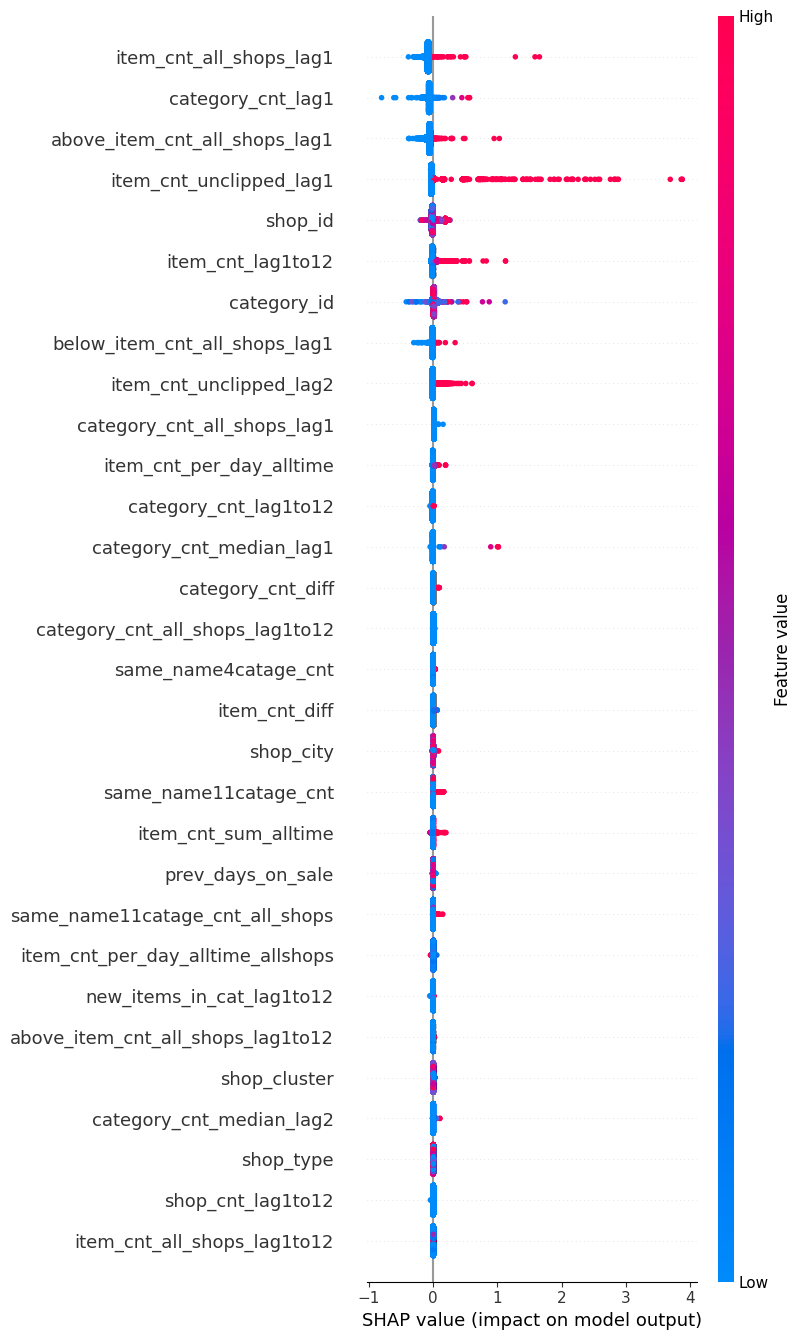

In [ ]:
temp = X_test.drop(columns='lgb_pred').sample(10000)
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(temp)
shap.summary_plot(shap_values, temp, max_display=30)

Make a chart of predicted vs. actual values

In [ ]:
fig = go.Figure(data=[
    go.Bar(name='Prediction',x=data.date,y=data.lgb_pred),
    go.Bar(name='Target',x=data.date,y=data.target)
])
fig.update_layout(
    title='Mean Prediction and Target Values by Month',
    xaxis={'title':'Month','type':'category'},
    yaxis={'title':'Mean Value'},
    legend={'yanchor':'top','y':1.05,'xanchor':'left','x':0.01},
    template='plotly_dark'
)

text = '''
    The model may not be adequately accounting for<br>
    the December sales spike. There is no systemic under or<br>
    over-prediction visible for the test month, November.
'''
fig.add_annotation(
    yref='paper', y=1.1,
    xref='paper', x=0.7,
    text=text,
    font={'size':11},
    showarrow=False)

text = '''
    Prediction mean is very close to the  <br>
    target mean in our validation set.
'''
fig.add_annotation(
    xref='paper', x=0.95,
    yref='paper', y=0.58,
    text=text,
    font={'size':11},
    showarrow=True, arrowhead=1)
fig.show()

Adding my submission code

In [1]:
test_submit = pd.read_csv('/kaggle/input/future-sales-data/test.csv')

submission = pd.DataFrame({
    "ID": test_submit["ID"],
    "item_cnt_month": X_test["lgb_pred"]
})

submission.to_csv("submission.csv", index=False)

submission.head()

NameError: name 'pd' is not defined